## Initial cleaning and preprocessing of corpus

In [1]:
import contractions
import csv
import ftfy
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle
import re
from collections import Counter, defaultdict
from unidecode import unidecode

%matplotlib inline

In [2]:
def init_reader(infile):
    """initialize csvreader to stream corpus"""
    csvfile = open(infile, "r")
    csvreader = csv.DictReader(csvfile, delimiter="\t", quotechar='"')
    return csvreader


def clean_batch(batch):
    """minimal preprocessing on a batch of documents"""
    init_len = len(batch)
    occupations, ratings, text = zip(*batch)
    text = [" ".join(t) for t in text]
    text = " <NEWREVIEW> ".join(text)
    text = ftfy.fix_encoding(text)
    text = unidecode(text)
    text = contractions.fix(text)
    text = re.sub("\+", " ", text)
    text = text.split("<NEWREVIEW>")
    assert len(text) == len(ratings) == len(occupations) == init_len
    batch = list(zip(occupations, ratings, text))
    assert len(batch) == init_len
    return batch


def make_batches(corpus, batch_size):
    """divide corpus in batches of batch_size"""
    remainder = len(corpus) % batch_size
    num_batches = int((len(corpus)-remainder)/batch_size)
    batches = []
    for i in range(num_batches):
        begin = i*batch_size
        end = begin + batch_size
        batches += [corpus[begin:end]]
    if remainder > 0:
        batches += [corpus[-remainder:]]
    return batches

 ## Set thresholds and file paths

In [3]:
infile = "reviews_no_duplicates.csv"

In [4]:
minimum_words = 10
minimum_documents_ratings = 500

## Initial pass through the data to begin weeding out underrepresented occupations

In [5]:
# there won't be enough data for every occupation; an initial pass to exclude

occ_rating_counts = defaultdict(lambda: defaultdict(lambda: 0))

occ_wc_c = defaultdict(lambda: {"total_words":0, "total_reviews":0})

reader = init_reader(infile)

for doc in reader:
    has_occ = len(doc["MGOC"].split()) > 0
    pros_len = len(doc["pros"].split()) >= minimum_words/2
    cons_len = len(doc["cons"].split()) >= minimum_words/2
    has_rating = doc["OverallRating"] != ""
    if not any(requirement == False for requirement in [has_occ, pros_len, cons_len, has_rating]):
        occ = doc["MGOC"]
        rating = doc["OverallRating"]
        occ_rating_counts[occ][rating] += 1
        occ_wc_c[occ]["total_reviews"] += 1
        text = doc["text"].split()
        occ_wc_c[occ]["total_words"] += len(text)

In [6]:
# just a sample occupation and the distribution of its reviews over the 1- to 5-star rating categories

test_occ = np.random.choice(list(occ_rating_counts.keys()))

print("Number of reviews per star rating for a sample occupation:")
print(test_occ, ": ", dict(occ_rating_counts[test_occ]))

Number of reviews per star rating for a sample occupation:
event coordinator :  {'1.0': 785, '4.0': 1516, '3.0': 1074, '2.0': 675, '5.0': 1942}


Total number of useable occupations: 158
Lowest number of reviews for any occupation: 722
Highest number of reviews for any occupation: 238903

Distribution of occupations:


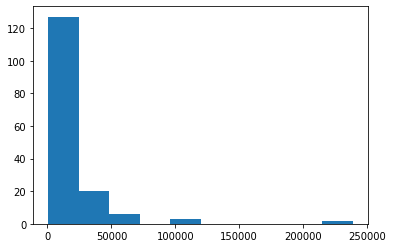

In [7]:
# number useable occupations, max/min, distribution

occ_counts = [sum([count for rating, count in occ.items()]) for occ in occ_rating_counts.values()]

print("Total number of useable occupations: {}".format(len(occ_rating_counts.keys())))

print("Lowest number of reviews for any occupation: {}".format(min(occ_counts)))
print("Highest number of reviews for any occupation: {}".format(max(occ_counts)))

print()
print("Distribution of occupations:")

plt.hist(occ_counts)
plt.show()

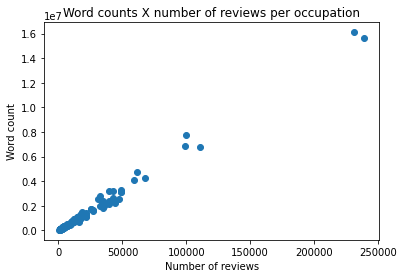

In [8]:
# wordcounts X number of reviews--outliers?

wordcounts = []
num_reviews = []

for key, value in occ_wc_c.items():
    wordcounts.append(value["total_words"])
    num_reviews.append(value["total_reviews"])
    
plt.title("Word counts X number of reviews per occupation")
plt.xlabel("Number of reviews")
plt.ylabel("Word count")
plt.scatter(num_reviews, wordcounts)
plt.show()

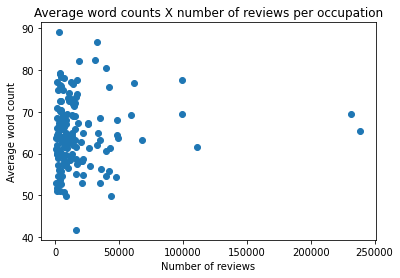

In [9]:
# average wordcount X number of reviews--outliers?

avg_wordcounts = []
num_reviews = []

for key, value in occ_wc_c.items():
    reviews = value["total_reviews"]
    num_reviews.append(reviews)
    avg_words = value["total_words"]/reviews
    avg_wordcounts.append(avg_words)
    
plt.title("Average word counts X number of reviews per occupation")
plt.xlabel("Number of reviews")
plt.ylabel("Average word count")
plt.scatter(num_reviews, avg_wordcounts)
plt.show()

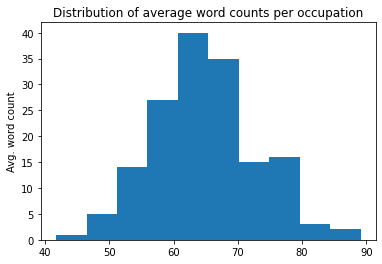

In [10]:
plt.title("Distribution of average word counts per occupation")
plt.hist(avg_wordcounts)
plt.ylabel("Avg. word count")
plt.show()

In [11]:
# Filter out occupations with fewer than minimum_document_ratings documents in any of the five ratings categories

occs = [key for key, value in occ_rating_counts.items() if not any(count < minimum_documents_ratings for count in value.values())]

Total number of occupations meeting criteria: 112
Lowest number of reviews for any occupation meeting initial criteria: 3302
Highest number of reviews for any occupation meeting initial critera: 238903

Distribution of occupations meeting initial criteria:


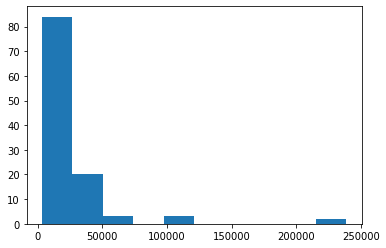

In [12]:
# Sum the total number of documents for each remaining occupation to see distribution
counts = [sum(value.values()) for key, value in occ_rating_counts.items() if key in occs]

print("Total number of occupations meeting criteria: {}".format(len(occs)))

print("Lowest number of reviews for any occupation meeting initial criteria: {}".format(min(counts)))
print("Highest number of reviews for any occupation meeting initial critera: {}".format(max(counts)))

print()
print("Distribution of occupations meeting initial criteria:")
plt.hist(counts)
plt.show()

In [13]:
# branch manager and sales representative are not only the largest groups, but also the most verbose--definite outliers

occ_tups = [(key, sum(value.values())) for key, value in occ_rating_counts.items() if key in occs]
occ_tups = sorted(occ_tups, key=lambda x: x[1], reverse=True)

print("10 Occupations with the most reviews that meet the initial criteria:", "\n")

for t in occ_tups[:20]:
    occ, count = t
    print("{}: {}".format(occ.capitalize(), count))

10 Occupations with the most reviews that meet the initial criteria: 

Branch manager: 238903
Sales representative: 231473
Retail representative: 110772
Software engineer: 99535
Customer service: 99010
Teacher: 67625
Marketing manager: 61347
Engineer: 59089
Project manager: 49087
Store manager: 48775
Analyst: 48754
Server: 47476
Student: 44117
Other: 42784
Administrative: 42531
Management consulting: 42481
Corporate account manager: 39753
Nursing: 39640
Operations: 39440
Unskilled labor: 35798


## Tradeoffs between minimum number of reviews/occupation, number of occupations retained in the corpus, and the total number of documents retained in the corpus

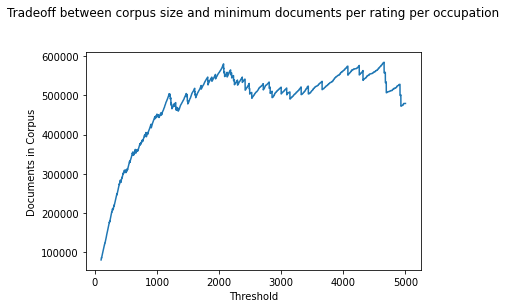

Tradeoffs for thresholds in range [100,5000]

Solution 1:

	Threshold: 2071
	Occupations: 50
	Documents in corpus 517750
	Minimum docs/occupation: 10355


Solution 2:

	Threshold: 2070
	Occupations: 50
	Documents in corpus 517500
	Minimum docs/occupation: 10350


Solution 3:

	Threshold: 2069
	Occupations: 50
	Documents in corpus 517250
	Minimum docs/occupation: 10345


Solution 4:

	Threshold: 2068
	Occupations: 50
	Documents in corpus 517000
	Minimum docs/occupation: 10340


Solution 5:

	Threshold: 2067
	Occupations: 50
	Documents in corpus 516750
	Minimum docs/occupation: 10335




In [14]:
# for each occupation in the final corpus, I want there to be a minimum of N documents for each *rating*
# (e.g., N 1-star reviews from software engineers, N 2-star reviews from software engineers, and so on)

min_document_ratings_test = 100
max_document_ratings_test = 5000

deviation = 1.2 # allow occupations to exceed minimum by a factor of this value to increase corpus size
                # e.g., if the minimum contribution to the corpus from an occupation is 100, others may contribute
                # up to 100*deviation documents, risking overrepresenting some occupations but increasing the 
                # corpus size

results = []
total_docs = []
total_occs = []

for i in range(min_document_ratings_test, max_document_ratings_test+1):
    to_keep = []
    removed = []
    total = 0
    limit = deviation*i
    min_count = 5*i
    for occ, ratings_dict in occ_rating_counts.items():
        keep = False
        ratings = np.array(list(ratings_dict.values()))
        if min_count <= sum(ratings_dict.values()):
            if not any(ratings < i):
                to_keep.append(occ)
                ratings_dev = []
                for num in ratings:
                    dev = deviation
                    count = dev*num
                    while count >= limit:
                        dev -= 0.05
                        count = dev*num
                    total += int(max(count, i))
                keep = True
        if not keep:
            removed.append(occ)
    total_docs.append(total)
    total_occs.append(len(to_keep))
    iter_results = [len(to_keep), min_count, min_count*len(to_keep), total, i]
    results.append(iter_results)

results = sorted(results, key=lambda x: x[2], reverse=True)

thresholds, doc_counts = zip(*list(enumerate(total_docs, start=min_document_ratings_test)))

print()

plt.plot(thresholds, doc_counts)
plt.title("Tradeoff between corpus size and minimum documents per rating per occupation\n\n")
plt.xlabel("Threshold")
plt.ylabel("Documents in Corpus")
plt.show()

print("Tradeoffs for thresholds in range [{},{}]".format(min_document_ratings_test, max_document_ratings_test))
print()

for i in range(1,6):
    print("Solution {}:".format(i))
    print()
    res = results[i]
    num_occs, min_docs, num_docs, _, thresh = res
    print("\tThreshold: {}\n\tOccupations: {}\n\tDocuments in corpus {}\n\tMinimum docs/occupation: {}\n\n".format(thresh, num_occs, num_docs, min_docs))

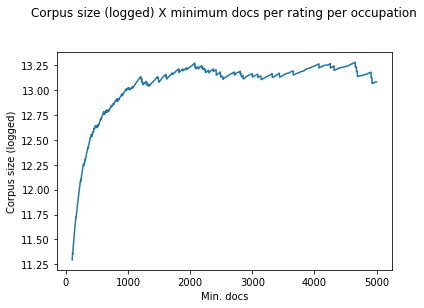

In [15]:
log_doc_counts = np.log(doc_counts)

plt.title("Corpus size (logged) X minimum docs per rating per occupation\n\n")
plt.plot(thresholds, log_doc_counts)
plt.xlabel("Min. docs")
plt.ylabel("Corpus size (logged)")
plt.show()

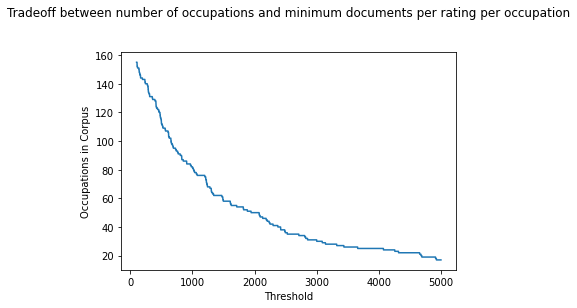

In [16]:
plt.plot(thresholds, total_occs)
plt.title("Tradeoff between number of occupations and minimum documents per rating per occupation\n\n")
plt.xlabel("Threshold")
plt.ylabel("Occupations in Corpus")
plt.show()

In [17]:
threshold = 2000

occupations_final = sorted([key for key, value in occ_rating_counts.items() if not any(count < threshold for count in value.values())])

In [18]:
len(occupations_final)

50

In [19]:
# writing a list of the selected occupation to disk

outfile = "final_occupation_list.txt"
with open(outfile, "w") as writer:
    for i, occ in enumerate(occupations_final, start=1):
        writer.write("{}\n".format(occ))

## Creating corpus

In [20]:
# reading in the list of selected occupations from disk

occupations_final = open("final_occupation_list.txt", "r").read().strip()
print(occupations_final)

occupations_final = occupations_final.split("\n")
print()
print(len(occupations_final))

academic counselor
account executive
accounting
administrative
analyst
beauty
branch manager
business analyst
claims
client services
corporate account manager
customer service
designer
driver
editor
engineer
field sales manager
finance specialist
food services
front desk
hr specialist
it
management consulting
marketing manager
medical technician
merchandiser
nursing
operations
other
patient care technician
police & security officers
program coordinator
project manager
quality assurance
recruiter
researcher
retail representative
sales representative
server
skilled labor
software engineer
stock clerk
store manager
systems administrator
systems technician
teacher
technical support
teller
underwriter
unskilled labor

50


In [21]:
minimum_words = 10
deviation = 1.2 # allow occupations to exceed minimum by a factor of this value to increase corpus size
                # e.g., if the minimum contribution to the corpus from an occupation is 100, others may contribute
                # up to 100*deviation documents, risking overrepresenting some occupations but increasing the 
                # corpus size

min_docs_per_rating = 2000 # based on analysis above

In [22]:
# pull out reviews I'll use, based on the above considerations

# note: with a minimum_words of 10, rejects any reviews with fewer than 5 words in the pros or cons sections;
# at least 5 in each and at least 10 total

data = []

reader = init_reader(infile)

for doc in reader:
    occ = doc["MGOC"]
    if occ in occupations_final:
        pros_len = len(doc["pros"].split()) >= minimum_words/2
        cons_len = len(doc["cons"].split()) >= minimum_words/2
        has_rating = doc["OverallRating"] != ""
        if not any(requirement == False for requirement in [pros_len, cons_len, has_rating]):
            rating = doc["OverallRating"]
            text = doc["text"].split()
            row = [occ, rating, text]
            data.append(row)

In [23]:
# finally create the dataframe

df = pd.DataFrame(data, columns=["occupation", "rating", "text"])
del data

outfile = "occupations_df.json"
df.to_json(outfile)

In [3]:
# backup an early version in case I change stuff below

df = pd.read_json("occupations_df.json")

In [27]:
df["wordcount"] = [len(t) for t in df["text"].values]

In [28]:
# filtering out reviews with fewer than the minimum number of words overall in the text (pros + cons)

df = df[df["wordcount"]>=minimum_words]

In [29]:
# quick sense of counts of remaining occupations--looked at histograms a thousand times already

df.groupby(["occupation"]).count()

,rating,text,wordcount
occupation,,,
academic counselor,16629,16629,16629
account executive,32631,32631,32631
accounting,27288,27288,27288
administrative,42531,42531,42531
analyst,48754,48754,48754
beauty,15289,15289,15289
branch manager,238903,238903,238903
business analyst,20187,20187,20187
claims,13830,13830,13830


In [30]:
# total number of words per occupation

df.groupby(["occupation"])["wordcount"].sum()

occupation
academic counselor             1224506
account executive              2834389
accounting                     1557254
administrative                 2371406
analyst                        3145659
beauty                         1101807
branch manager                15644551
business analyst               1267384
claims                          953444
client services                1081495
corporate account manager      3199090
customer service               6874522
designer                       1343185
driver                         2223581
editor                         1510635
engineer                       4094602
field sales manager            2385328
finance specialist             2201240
food services                  1861233
front desk                     1263606
hr specialist                  1637982
it                             1718150
management consulting          3230163
marketing manager              4725078
medical technician              994108
merchandiser  

In [31]:
df

,occupation,rating,text,wordcount
0,branch manager,5.0,"[Excellent, benefits, Autonomy, Adaptable, and...",106
1,field sales manager,5.0,"[We, had, great, support, from, team, members,...",18
2,beauty,4.0,"[Very, talented, team, and, it's, easy, to, be...",32
3,account executive,4.0,"[Excellent, culture, driven, by, consistent, c...",161
4,branch manager,1.0,"[Sunday's, off, and, pay..thats, all, Horrible...",17
...,...,...,...,...
2143917,branch manager,2.0,"[large, company,, good, benefits,, sufficient,...",16
2143918,sales representative,5.0,"[They, really, take, care, of, their, employee...",40
2143919,retail representative,1.0,"[-, Great, health, benefits, -, Nice, coworker...",520
2143920,designer,4.0,"[Nice, &amp;, interesting, coworkers,, kind, d...",82


In [33]:
np.random.seed(9982) # from random.org; integer in range [1,10000]

In [34]:
# maybe the more opaque part of this notebook:
# Subsets the dataframe for each occupation.
# From there, subsets a dataframe for each rating (1-star to 5-star).
# From there, selects AT MOST "limit" reviews for that occupation X rating combination, where
# "limit" is the minimum number of documents * the maximum "deviation" (factor limiting how many "extra" reviews
# can come from an occupation X rating combination, risking overrepresenting some groups but making
# the corpus larger)

corpus = []

ratings = sorted(set(df["rating"].values))

for occupation in occupations_final:
    occ_df = df[df["occupation"]==occupation]
    for rating in ratings: #["1.0", "2.0", "3.0", "4.0", "5.0"]:
        occ_rat_df = occ_df[occ_df["rating"]==rating]
        num_rows = occ_rat_df.shape[0]
        limit = min_docs_per_rating*deviation
        num_rows = min(num_rows, limit)
        while num_rows > limit:
            num_rows -= 1
        sample = np.random.choice(occ_rat_df["text"], size=int(num_rows), replace=False)
        assert len(sample) == num_rows
        sample = list(zip([occupation]*int(num_rows), [rating]*int(num_rows), sample))
        assert len(sample) == num_rows
        corpus += sample
    print("Finished sample for occupation {}".format(occupation))

Finished sample for occupation academic counselor
Finished sample for occupation account executive
Finished sample for occupation accounting
Finished sample for occupation administrative
Finished sample for occupation analyst
Finished sample for occupation beauty
Finished sample for occupation branch manager
Finished sample for occupation business analyst
Finished sample for occupation claims
Finished sample for occupation client services
Finished sample for occupation corporate account manager
Finished sample for occupation customer service
Finished sample for occupation designer
Finished sample for occupation driver
Finished sample for occupation editor
Finished sample for occupation engineer
Finished sample for occupation field sales manager
Finished sample for occupation finance specialist
Finished sample for occupation food services
Finished sample for occupation front desk
Finished sample for occupation hr specialist
Finished sample for occupation it
Finished sample for occupatio

In [35]:
len(corpus)

596984

In [36]:
# example

print(corpus[10000])

('academic counselor', '5.0', ['The', 'opportunity', 'to', 'help', 'people', 'in', 'the', 'pursuit', 'of', 'lifelong', 'goals', 'and', 'achievements', 'was', 'extremely', 'rewarding.', 'Everyday', 'you', 'make', 'a', 'few', 'hundred', 'phone', 'calls,', 'but', 'get', 'a', 'chance', 'to', 'build', 'lasting', 'relationships', 'with', 'people', 'who', 'are', 'soon', 'to', 'forget', 'fear', 'and', 'embrace', 'confidence', 'as', 'they', 'move', 'on', 'to', 'reach', 'a', 'goal', 'that', 'may', 'have', 'seemed', 'far,', 'far', 'away', 'at', 'one', 'point', 'in', 'their', 'lives.', 'Ashford', 'University', 'and', 'its', 'parent', 'company', 'Bridgepoint', 'Education', 'also', 'gives', 'its', 'employees', 'a', 'tuition', 'remission', 'program', 'where', 'an', 'employee', 'can', 'finish', 'an', 'undergraduate', 'degree,', "master's", 'degree,', 'or', 'even', 'a', 'doctoral', 'degree.', 'The', 'hardest', 'part', 'of', 'this', 'job', 'for', 'me', 'was', 'sitting/standing', 'at', 'a', 'desk', 'all'

In [37]:
# another example

print(corpus[500000])

('stock clerk', '5.0', ["It's", 'a', 'great', 'place', 'to', 'work', 'for', 'college', 'kids.', 'If', 'you', 'want', 'a', 'career', 'get', 'ready', 'for', 'a', 'lot', 'of', 'long', 'hours.', 'Depends', 'on', 'the', 'management', 'your', 'experience', 'can', 'be', 'good', 'or', 'really', 'bad.'])


## Minimal preprocessing

In [38]:
# minimal preprocessing in batches to take advantage of multiprocessing + not running the same code on every
# individual review

batch_size = 1000

batches = make_batches(corpus, batch_size)

In [39]:
len(batches)

597

In [40]:
set([len(b) for b in batches])

{984, 1000}

In [41]:
# did the batches get divided up right?

assert sum([len(b) for b in batches]) == len(corpus)

In [ ]:
# apply the minimal preprocessing to the documents in each batch, for all batches

pool = mp.Pool(mp.cpu_count()-1)
batches = pool.map(clean_batch, batches)
pool.close()

In [28]:
# number of batches unchanged. good sign

len(batches)

597

In [79]:
# flattening this from a list of lists (batches) of reviews to a list of review

preprocessed = [review for batch in batches for review in batch]

In [80]:
# total number of reviews in preprocessed corpus

len(preprocessed)

596984

In [81]:
# throwing out any reviews that shrank below 10 words

preprocessed = [(review[0], review[1], review[2].strip()) for review in preprocessed if len(review[2].split()) >= 10]

In [82]:
# only lost two reviews

len(preprocessed)

596982

In [90]:
# extraneous checks

occ_rating_count2 = defaultdict(lambda: defaultdict(lambda: 0))

for review in preprocessed:
    occ = review[0]
    rating = review[1]
    occ_rating_count2[occ][rating] += 1

In [87]:
# occ_rating_count2["merchandiser"].values()

In [91]:
# extraneous checks

rcounts = []

for occ in occ_rating_count2.keys():
    ratings_dict = occ_rating_count2[occ]
    for count in ratings_dict.values():
        rcounts.append(count)
        if count < 2000:
            print(occ)

In [88]:
# set(rcounts)

In [89]:
# Counter(rcounts)

In [92]:
# putting the resulting corpus together as a dataframe

corpus_df = pd.DataFrame(preprocessed, columns=["occupation", "rating", "text"])

In [96]:
# here it is

corpus_df

,occupation,rating,text
0,academic counselor,1,"I love the Medialle Students, they are sweet a..."
1,academic counselor,1,Paid vacation time and built in holidays. Ther...
2,academic counselor,1,Coworkers are good people. The terms and paper...
3,academic counselor,1,They pay really well to treat you like garbage...
4,academic counselor,1,If you like for your calls to be recorded and ...
...,...,...,...
596977,unskilled labor,5,UPS is a great company to work for. I work at ...
596978,unskilled labor,5,You got to be trained in many departments. Dep...
596979,unskilled labor,5,Production work You can bank if you are a work...
596980,unskilled labor,5,Great environment decent pay with the ability ...


In [97]:
# saving to disk before splitting into train, dev, and test set
df["labels"] = [label_dict["_".join(occ.split())] for occ in df["occupation"].values]
corpus_df.to_json("cs230_corpus_final.json")

In [13]:
# Mean and median in final corpus
text = list(df["text"].values)
wordcounts = [len(t.split()) for t in text]
print("Mean wordcount: {}".format(np.mean(wordcounts)))
print("Median wordcount: {}".format(np.median(wordcounts)))

Mean wordcount: 55.94707529462445
Median wordcount: 45.0


# Splitting into train, dev, and test sets

In [ ]:
# Data include 49 occupations (after excluding "other"), and reviews can have anywhere from one to five stars.
# I wanted to balance the training and dev sets so no particular occupation (or occupation X rating combination) 
# was overrepresented. To do this, for each occupation X rating pair (e.g., 5-star reviews by software engineer),
# I sampled 8,000 training examples and 2,000 dev examples, for a total of 392,000 train examples and 98,000
# dev examples.
# 49 occupations * five rating categories * 8,000 reviews = 392,000 train examples.
# 49 occupations * five rating categories * 2,000 reviews = 98,000 dev examples.

def return_balanced_subset(lab_df):
    """returns samples of reviews for each occupation
    stratified by star-rating"""
    trains_ = []
    devs_ = []
    lab_df = shuffle(lab_df)
    for rating in ratings:
        rat_df = lab_df[lab_df["rating"]==rating]
        rat_df = rat_df.sample(2000)
        train_, dev_ = train_test_split(rat_df, test_size=0.2)
        trains_.append(train_)
        devs_.append(dev_)
    trains_ = pd.concat(trains_, ignore_index=True)
    devs_ = pd.concat(devs_, ignore_index=True)
    assert trains_.shape[0] == 8000
    assert devs_.shape[0] == 2000
    return trains_, devs_


df = pd.read_json("cs230_corpus_final.json")
df = df[df["occupation"]!="other"] # I thought the "other" category would add too much noise
df["id"] = np.random.randint(100000,999999,df.shape[0])

classes = sorted(list(set(df["occupation"].values)))
label_dict = {}
for i, cat in enumerate(classes):
    label_dict[cat] = i
df["labels"] = [label_dict[occ] for occ in df["occupation"].values]
assert "other" not in label_dict.keys()

ratings = sorted(list(set(df["rating"].values)))

train_lab_dfs = [] # append random samples of each occupation X rating combination for train set
dev_lab_dfs = [] # append random samples of each occupation X rating combination for dev set

for lab in label_dict.keys():
    lab_df = df[df["occupation"] == lab]
    train_lab_df, dev_lab_df = return_balanced_subset(lab_df) # train and dev samples for each occupation-rating pair
    train_lab_dfs.append(train_lab_df)
    dev_lab_dfs.append(dev_lab_df)

train_df = pd.concat(train_lab_dfs, ignore_index=True) # combine the stratified samples into the overall train set
dev_df = pd.concat(dev_lab_dfs, ignore_index=True) # combine the stratified samples into the overall train set

train_df.to_json("train_df_final.json") # save the train set to disk
dev_df.to_json("dev_df_final.json") # save the dev set to disk

In [ ]:
# I had previously assigned a random, six-digit ID number to each review. To create the test set, I first
# merged the train and dev sets; I then created a list of all of the IDs in the train and dev sets.
# To create the test set, I first took the subset of reviews whose IDs were NOT in the the list of taken IDs.
# For the test set, I randomly sampled a total of 49,000 examples that did not overlap with the train or dev sets.
# 49 occupations * five rating categories * 200 reviews = 49,000.

train_dev = pd.concat([train_df, dev_df]) # a combination of the train and dev sets to get the IDs of reviews in use
taken_ids = [id_ for id_ in train_dev["id"].values] # the list of IDs of reviews in the train and dev sets
df = df[~df["id"].isin(taken_ids)] # get the subset of reviews that aren't in the train or dev sets (using ID)

dfs_for_test = [] # previously-unused samples for each occupation-rating pair

for lab in label_dict.values():
    lab_df = df[df["labels"]==lab]
    for rating in ratings:
        rat_df = lab_df[lab_df["rating"]==rating]
        if rat_df.shape[0] > 200:
            rat_df = rat_df.sample(200)
        dfs_for_test.append(rat_df)

test_df = pd.concat(dfs_for_test) # combine the samples to create the test set (49,000 examples)
test_df.to_json("test_df_final.json")